In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import h5py
import os
import time
import pickle

import scanpy.api as sc
import sceb.data_loader as dl 
import sceb.scdd as sd

%matplotlib inline
%load_ext autoreload
%autoreload 2

from matplotlib import rcParams

params = {
   'axes.labelsize': 16,
   'font.size': 16,
   'legend.fontsize': 10,
   'xtick.labelsize': 13,
   'ytick.labelsize': 13,
   'text.usetex': False,
   'text.usetex': False,
   }
rcParams.update(params)

/home/martin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
output_folder = '/home/martin/single_cell_eb/figures/figure_tradeoff_curve_simu'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [3]:
## Read subsample parameters
fname = '/home/martin/single_cell_eb/figures/figure_tradeoff_curve/subsample_param.pickle'
f_myfile = open(fname, 'rb')
B_sub_list = pickle.load(f_myfile)
subsample_param_dic = pickle.load(f_myfile)
f_myfile.close()

# Generate a nice toy example (from 4k)

In [136]:
data = dl.load_10x_4k()
gene_list = ['CD3D','CD3E','NKG7','GZMA'] # some marker genes 
mean_count = np.array(data.X.mean(axis=0)).reshape(-1)
sort_idx = np.argsort(mean_count)[::-1]
G = 200
gene_list = list(data.var_names[sort_idx[0:G]])

Y = np.array(data[:,gene_list].X.todense()).astype(dtype=int)
Y = Y.clip(max=np.percentile(Y,99)).astype(dtype=int)

p_true = np.ones([Y.shape[0]])
p_true = p_true / np.sum(p_true)
x_true = Y / np.sum(Y) * Y.shape[0]

## calculate the related quantities
M_true = np.zeros([2,x_true.shape[1]])
M_true[0] = np.mean(x_true,axis=0)
M_true[1] = np.mean(x_true**2,axis=0)
mean_true = x_true.mean(axis=0)
var_true = x_true.var(axis=0)
cv_true = np.sqrt(var_true)/mean_true
gamma_param_true = sd.M_to_gamma(M_true)

cov_true = np.cov(x_true.T)
_,V_true = np.linalg.eigh(cov_true)
PeCo_true = np.corrcoef(x_true.T)
p0_true = np.mean(x_true==0,axis=0)
kappa = G
temp = np.exp(-kappa*x_true)
inactive_true = np.mean(temp,axis=0)
pairwise_inactive_true = temp.T.dot(temp)/temp.shape[0]
np.fill_diagonal(pairwise_inactive_true,inactive_true)
##
dist_true = {}
for i in range(Y.shape[1]):
    p_dist_true_1d = np.bincount(Y[:,i])
    p_dist_true_1d = p_dist_true_1d / np.sum(p_dist_true_1d)
    x_dist_true_1d = np.arange(p_dist_true_1d.shape[0])
    dist_true[i] = [p_dist_true_1d,x_dist_true_1d]

print('## cv_true',cv_true[0:3])
print('## PC_true')
print(PeCo_true[0:3,0:3])

print('## p0_true')
print(p0_true[0:3])

print('## inactive_true')
print(inactive_true[0:3])

print('## pairwise_inactive_true')
print(pairwise_inactive_true[0:3,0:3])

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
## cv_true [0.12604958 0.41381514 0.45577658]
## PC_true
[[1.         0.08030608 0.39967556]
 [0.08030608 1.         0.11285768]
 [0.39967556 0.11285768 1.        ]]
## p0_true
[0.         0.         0.00023041]
## inactive_true
[0.00341799 0.04128122 0.05950824]
## pairwise_inactive_true
[[0.00341799 0.00013661 0.00117663]
 [0.00013661 0.04128122 0.00325376]
 [0.00117663 0.00325376 0.05950824]]


# Diagnosis

In [47]:
## cv 
M_ml,M_dd = sd.dd_1d_moment(data,verbose=False,size_factor=size_factor)
cv_ml = sd.M_to_cv(M_ml)
cv_dd = sd.M_to_cv(M_dd)
print('## cv_true',cv_true[0:3])
print('## cv_ml',cv_ml[0:3])
print('## cv_dd',cv_dd[0:3])


## cv_true [0.45322517 0.79907628 0.53072199]
## cv_ml [0.48844569 0.85793057 0.63389615]
## cv_dd [0.45825223 0.80430885 0.54748459]


In [137]:
Nr = 300
data,size_factor = dl.poi_data_gen_nd(p_true,x_true,Nr=Nr,Nc=100)

mean_ml,cov_ml,PeCo_ml = sd.ml_covariance(data,size_factor=size_factor,verbose=False)
mean_dd,cov_dd,PeCo_dd = sd.dd_covariance(data,size_factor=size_factor,verbose=False,PC_prune=False)

err_ml = np.log10(np.mean((PeCo_true-PeCo_ml)**2)) - np.log10(np.mean(PeCo_true**2))
err_dd = np.log10(np.mean((PeCo_true-PeCo_dd)**2)) - np.log10(np.mean(PeCo_true**2))

print('err_ml',err_ml)
print('err_dd',err_dd)



err_ml -0.5017692758925772
err_dd -0.2697257865937609


# Simulation on the toy 4k-pbmc example

In [10]:
n_rep = 10
G = len(gene_list)

test_list = ['mean','var','cv','gamma_theta','gamma_r','cov','PC','PCA','zero','pw_zero','dist']

## use a two-layer dic to store the result
err_ml_dic = {}
err_dd_dic = {}

for test_type in test_list:
    err_ml_dic[test_type] = {}
    err_dd_dic[test_type] = {}

start_time = time.time()

for B in subsample_param_dic.keys():
    for i in range(len(subsample_param_dic[B][0])):
        Nr_bar = subsample_param_dic[B][0][i]
        Nc = subsample_param_dic[B][1][i]
        Nr = Nr_bar*G
        key_ = '%d_%0.2f_%0.2f_%d'%(B,Nr_bar,Nr,Nc)
        
        for test_type in test_list:            
            err_ml_dic[test_type][key_] = []
            err_dd_dic[test_type][key_] = []
            
        print(key_)
        for i_rep in range(n_rep):
            
            ## Data generation
            data,size_factor = dl.poi_data_gen_nd(p_true,x_true,Nc=Nc,Nr=Nr,random_seed=i_rep)
            
            ## mean,var,cv 
            M_ml,M_dd = sd.dd_1d_moment(data,verbose=False,size_factor=size_factor)
            
            err_ml = np.log10(np.mean((mean_true-M_ml[0]/Nr)**2)) - np.log10(np.mean(mean_true**2))
            err_dd = np.log10(np.mean((mean_true-M_dd[0]/Nr)**2)) - np.log10(np.mean(mean_true**2))
            err_ml_dic['mean'][key_].append(err_ml)
            err_dd_dic['mean'][key_].append(err_dd)
            
            
            var_ml = sd.M_to_var(M_ml)
            var_dd = sd.M_to_var(M_dd)
            err_ml = np.log10(np.mean((var_true-var_ml/Nr**2)**2)) - np.log10(np.mean(var_true**2))
            err_dd = np.log10(np.mean((var_true-var_dd/Nr**2)**2)) - np.log10(np.mean(var_true**2))
            err_ml_dic['var'][key_].append(err_ml)
            err_dd_dic['var'][key_].append(err_dd)
            
            cv_ml = sd.M_to_cv(M_ml)
            cv_dd = sd.M_to_cv(M_dd)
            err_ml = np.log10(np.mean((cv_true-cv_ml)**2)) - np.log10(np.mean(cv_true**2))
            err_dd = np.log10(np.mean((cv_true-cv_dd)**2)) - np.log10(np.mean(cv_true**2))
            err_ml_dic['cv'][key_].append(err_ml)
            err_dd_dic['cv'][key_].append(err_dd)
            
            gamma_param_ml = sd.M_to_gamma(M_ml)
            gamma_param_ml[0] /= Nr
            gamma_param_dd = sd.M_to_gamma(M_dd)
            gamma_param_dd[0] /= Nr
            err_ml = np.log10(np.mean((gamma_param_true[0]-gamma_param_ml[0])**2))\
                     - np.log10(np.mean(gamma_param_true[0]**2))
            err_dd = np.log10(np.mean((gamma_param_true[0]-gamma_param_dd[0])**2))\
                     - np.log10(np.mean(gamma_param_true[0]**2))
            err_ml_dic['gamma_theta'][key_].append(err_ml)
            err_dd_dic['gamma_theta'][key_].append(err_dd)
            err_ml = np.log10(np.mean((gamma_param_true[1]-gamma_param_ml[1])**2))\
                     - np.log10(np.mean(gamma_param_true[1]**2))
            err_dd = np.log10(np.mean((gamma_param_true[1]-gamma_param_dd[1])**2))\
                     - np.log10(np.mean(gamma_param_true[1]**2))
            err_ml_dic['gamma_r'][key_].append(err_ml)
            err_dd_dic['gamma_r'][key_].append(err_dd)
            
            ## PC and PCA
            mean_ml,cov_ml,PeCo_ml = sd.ml_covariance(data,size_factor=size_factor,verbose=False)
            mean_dd,cov_dd,PeCo_dd = sd.dd_covariance(data,size_factor=size_factor,verbose=False,PC_prune=False)
            
            err_ml = np.log10(np.mean((cov_true-cov_ml/Nr**2)**2)) - np.log10(np.mean(cov_true**2))
            err_dd = np.log10(np.mean((cov_true-cov_dd/Nr**2)**2)) - np.log10(np.mean(cov_true**2))
            err_ml_dic['cov'][key_].append(err_ml)
            err_dd_dic['cov'][key_].append(err_dd)
            
            err_ml = np.log10(np.mean((PeCo_true-PeCo_ml)**2)) - np.log10(np.mean(PeCo_true**2))
            err_dd = np.log10(np.mean((PeCo_true-PeCo_dd)**2)) - np.log10(np.mean(PeCo_true**2))
            err_ml_dic['PC'][key_].append(err_ml)
            err_dd_dic['PC'][key_].append(err_dd)

            ## PCA
            _,V_ml = np.linalg.eigh(cov_ml)
            _,V_dd = np.linalg.eigh(cov_dd)
            err_ml = np.log10(sd.cosine_distance(V_true[:,-1],V_ml[:,-1]))
            err_dd = np.log10(sd.cosine_distance(V_true[:,-1],V_dd[:,-1]))            
            err_ml_dic['PCA'][key_].append(err_ml)
            err_dd_dic['PCA'][key_].append(err_dd)
            
            ## zero                        
            p0_ml,p0_dd = sd.dd_inactive_prob(data,relative_depth=Nr/kappa,size_factor=size_factor,verbose=False)
            err_ml = np.log10(np.mean((p0_ml-inactive_true)**2)) - np.log10(np.mean(inactive_true**2))
            err_dd = np.log10(np.mean((p0_dd-inactive_true)**2)) - np.log10(np.mean(inactive_true**2))
            err_ml_dic['zero'][key_].append(err_ml)
            err_dd_dic['zero'][key_].append(err_dd)
            
            ## pw zero
            pw_p0_ml,pw_p0_dd = sd.dd_pairwise_inactive_prob(data,relative_depth=Nr/kappa,\
                                                             size_factor=size_factor,verbose=False)
            err_ml = np.log10(sd.d_PC(pairwise_inactive_true,pw_p0_ml)) - np.log10(np.mean(pairwise_inactive_true**2))
            err_dd = np.log10(sd.d_PC(pairwise_inactive_true,pw_p0_dd)) - np.log10(np.mean(pairwise_inactive_true**2))
            err_ml_dic['pw_zero'][key_].append(err_ml)
            err_dd_dic['pw_zero'][key_].append(err_dd)

            
            ## distribution
            data,size_factor = dl.poi_data_gen_nd(p_true,x_true,sigma=0,Nc=Nc,Nr=Nr,random_seed=i_rep)
            err_ml,err_dd = 0,0
            for i_dim in range(data.shape[1]):
                Y = np.array(data[:,i_dim].X).astype(int)

                p_ml = np.bincount(Y)
                p_ml = p_ml / np.sum(p_ml)
                x_ml = np.arange(p_ml.shape[0])

                p_dd,x_dd = sd.dd_distribution(Y,gamma=None,verbose=False)

                p_true_,x_true_ = dist_true[i_dim]

                err_ml += dist_W1(p_true_,p_ml,x_true_,x_ml)/data.shape[1]
                err_dd += dist_W1(p_true_,p_dd,x_true_,x_dd)/data.shape[1]

            
            err_ml_dic['dist'][key_].append(np.log10(err_ml))
            err_dd_dic['dist'][key_].append(np.log10(err_dd))

## Save the data
fname = output_folder+'/data/tradeoff_error_statistics.pickle'
f_myfile = open(fname,'wb')
pickle.dump(err_ml_dic, f_myfile)
pickle.dump(err_dd_dic, f_myfile)
f_myfile.close()

print('total time: %0.1f'%(time.time()-start_time))

44014_0.02_6.00_30565


KeyboardInterrupt: 

# Draw the figures

In [8]:
file_folder = output_folder + '/data'
file_list = os.listdir(file_folder)
error_ml_dic = {}
error_dd_dic = {}
for fname in file_list:
    if '.pickle' in fname:
        f_myfile = open(file_folder+'/'+fname, 'rb')
        error_ml_dic_ = pickle.load(f_myfile)
        error_dd_dic_ = pickle.load(f_myfile)
        f_myfile.close()
        
        for key_test in error_ml_dic_.keys():
            if key_test not in error_ml_dic:
                error_ml_dic[key_test] = {}
                error_dd_dic[key_test] = {}
            for key_config in error_ml_dic_[key_test].keys():
                if key_config not in error_ml_dic[key_test]:
                    error_ml_dic[key_test][key_config] = []
                    error_dd_dic[key_test][key_config] = []
                error_ml_dic[key_test][key_config] += error_ml_dic_[key_test][key_config]
                error_dd_dic[key_test][key_config] += error_dd_dic_[key_test][key_config]     

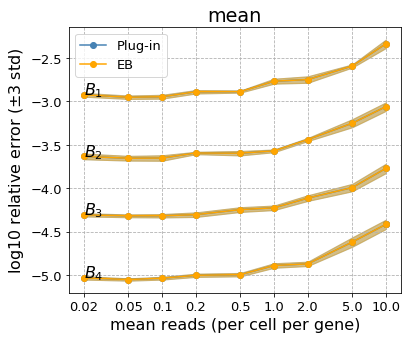

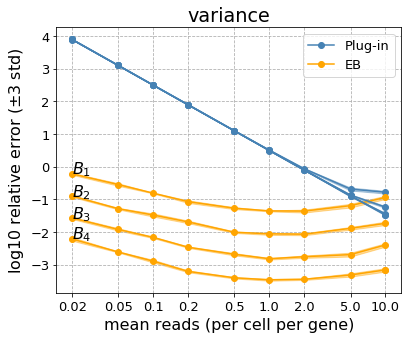

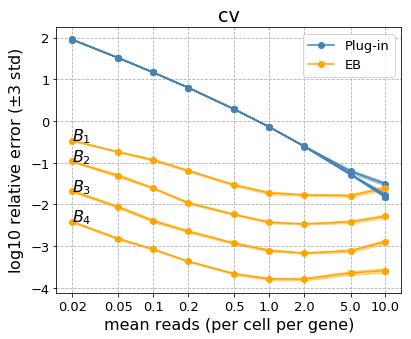

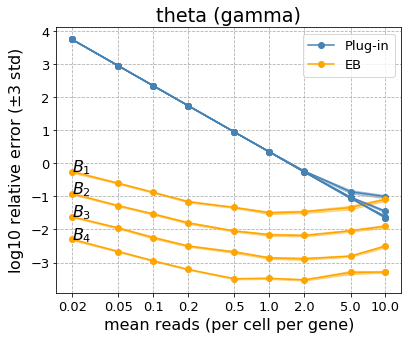

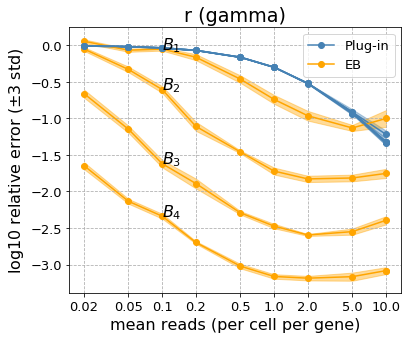

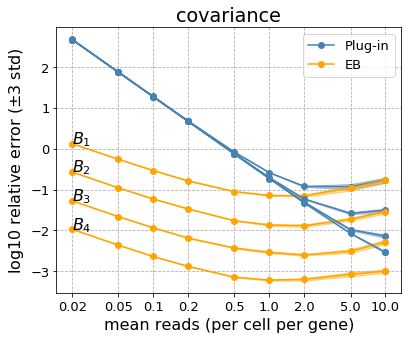

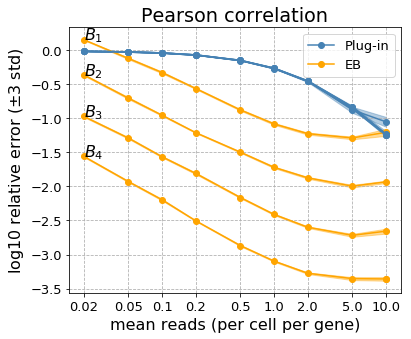

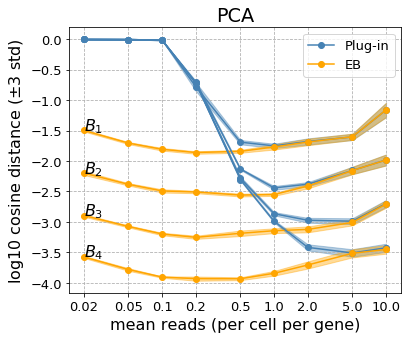

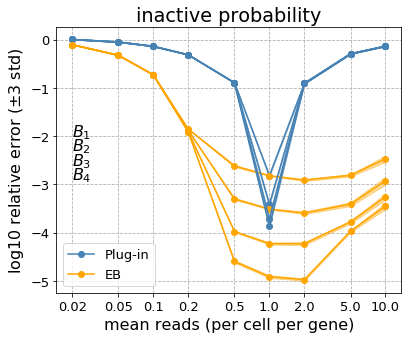

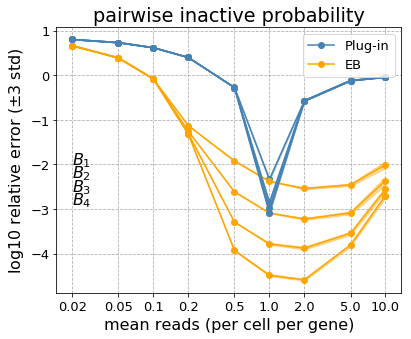

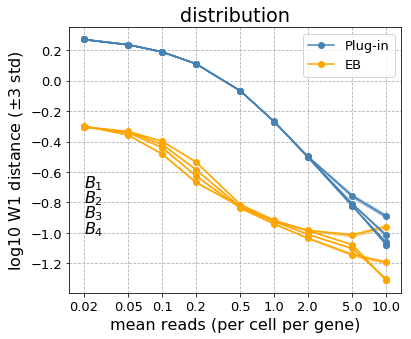

In [9]:
## Read data statistics 
# fname = output_folder+'/data/tradeoff_error_statistics.pickle'
# f_myfile = open(fname, 'rb')
# error_ml_dic = pickle.load(f_myfile)
# error_dd_dic = pickle.load(f_myfile)
# f_myfile.close()

    

sd.plot_tradeoff_curve(error_ml_dic['mean'],error_dd_dic['mean'],output_folder=output_folder,suffix='mean',\
                               ylabel='log10 relative error ($\pm$3 std)',title='mean',\
                               ann_ml=None,ann_dd=0)

sd.plot_tradeoff_curve(error_ml_dic['var'],error_dd_dic['var'],output_folder=output_folder,suffix='var',\
                               ylabel='log10 relative error ($\pm$3 std)',title='variance',\
                               ann_ml=None,ann_dd=0)

sd.plot_tradeoff_curve(error_ml_dic['cv'],error_dd_dic['cv'],output_folder=output_folder,suffix='cv',\
                               ylabel='log10 relative error ($\pm$3 std)',title='cv',\
                               ann_ml=None,ann_dd=0)

sd.plot_tradeoff_curve(error_ml_dic['gamma_theta'],error_dd_dic['gamma_theta'],output_folder=output_folder,suffix='gamma_theta_',\
                       ylabel='log10 relative error ($\pm$3 std)',title='theta (gamma)',\
                      ann_ml=None,ann_dd=0)

sd.plot_tradeoff_curve(error_ml_dic['gamma_r'],error_dd_dic['gamma_r'],output_folder=output_folder,suffix='gamma_r_',\
                       ylabel='log10 relative error ($\pm$3 std)',title='r (gamma)',\
                      ann_ml=None,ann_dd=2)

sd.plot_tradeoff_curve(error_ml_dic['cov'],error_dd_dic['cov'],output_folder=output_folder,suffix='cov',\
                               ylabel='log10 relative error ($\pm$3 std)',title='covariance',\
                               ann_ml=None,ann_dd=0)

sd.plot_tradeoff_curve(error_ml_dic['PC'],error_dd_dic['PC'],output_folder=output_folder,suffix='PC',\
                               ylabel='log10 relative error ($\pm$3 std)',title='Pearson correlation',\
                               ann_ml=None,ann_dd=0)

sd.plot_tradeoff_curve(error_ml_dic['PCA'],error_dd_dic['PCA'],output_folder=output_folder,suffix='PCA',\
                               ylabel='log10 cosine distance ($\pm$3 std)',title='PCA',\
                               ann_ml=None,ann_dd=0)

sd.plot_tradeoff_curve(error_ml_dic['zero'],error_dd_dic['zero'],output_folder=output_folder,suffix='zero',\
                               ylabel='log10 relative error ($\pm$3 std)',title='inactive probability',\
                               ann_ml=None,ann_dd=None,ann_offset=-2)

sd.plot_tradeoff_curve(error_ml_dic['pw_zero'],error_dd_dic['pw_zero'],output_folder=output_folder,suffix='pw_zero',\
                               ylabel='log10 relative error ($\pm$3 std)',title='pairwise inactive probability',\
                               ann_ml=None,ann_dd=None,ann_offset=-2)

sd.plot_tradeoff_curve(error_ml_dic['dist'],error_dd_dic['dist'],output_folder=output_folder,suffix='dist',\
                               ylabel='log10 W1 distance ($\pm$3 std)',title='distribution',\
                               ann_ml=None,ann_dd=None,ann_offset=-0.7,ann_step=0.1)